In [2]:
import numpy as np 
import pandas as pd
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Subset
from torchvision import models

import os
import time
from tqdm import tqdm

In [3]:
# ======================= PYTHON SETTINGS ======================= #
# =======================   GPU or CPU    ======================= #
# Check if GPU is available -> CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))

# Apple Silicon GPU
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    out = torch.ones(1, device=mps_device)
    print (out)
    print ("MPS device found. - Apple Silicon GPU")
else:
    print ("MPS device not found.")

# =======================   Ranom Seeds   ======================= #
# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# =============================================================== #

tensor([1.], device='mps:0')
MPS device found. - Apple Silicon GPU


In [4]:
# ======================= NORMALIZE PARAMS ======================= #
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize(           # Normalize the images
        # average values of the red, green, 
        # and blue channels across all images in the ImageNet dataset.
        mean=[0.485, 0.456, 0.406], 
        # standard deviation of the red, green, and blue 
        # channels across all images in the ImageNet dataset.
        std=[0.229, 0.224, 0.225]   
    )
])

In [5]:
# ======================= LOAD MAIN DATASET ======================= #
# Download and load the Food101 dataset
train_dataset = torchvision.datasets.Food101(
    root='./data',                 # Directory to save the downloaded data
    split='train',
    download=True,                 # Download the data if not present
    transform=transform            # Apply the transform to the data
)

test_dataset = torchvision.datasets.Food101(
    root='./data',                 # Directory to save the downloaded data
    split='test',
    download=True,                 # Download the data if not present
    transform=transform            # Apply the transform to the data
)

100%|██████████| 4996278331/4996278331 [07:15<00:00, 11467981.04it/s]


Extracting ./data/food-101.tar.gz to ./data


In [6]:
# def get_labels_from_loader(loader):
#     labels = []
#     for _, label in loader:
#         labels.extend(label.tolist())
#     return labels

# def get_subset_with_n_classes(original_dataset, n_classes, batch_size=64):
#     # Check if the dataset is a Subset
#     if isinstance(original_dataset, Subset):
#         # Create a DataLoader to extract labels from the Subset
#         subset_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False)
#         # Extract labels
#         targets = get_labels_from_loader(subset_loader)
#     else:
#         # Try to access labels through the targets attribute
#         try:
#             targets = original_dataset.targets
#         except AttributeError:
#             # If targets attribute doesn't exist, use __getitem__ method
#             targets = [original_dataset[i][1] for i in range(len(original_dataset))]

#     # Find the unique classes and select the first n
#     unique_classes = torch.unique(torch.tensor(targets))
#     selected_classes = unique_classes[:n_classes].tolist()

#     # Get the indices of samples belonging to the selected classes
#     selected_indices = [i for i, t in enumerate(targets) if t in selected_classes]

#     # Handle if the dataset is already a Subset
#     if isinstance(original_dataset, Subset):
#         # Adjust indices to map to the original dataset
#         original_indices = [original_dataset.indices[i] for i in selected_indices]
#         # Create a new Subset from the original dataset
#         subset = Subset(original_dataset.dataset, original_indices)
#     else:
#         # Create a new Subset
#         subset = Subset(original_dataset, selected_indices)

#     return subset

def get_labels_from_loader(loader):
    # Concatenate all labels into a single NumPy array for efficiency
    return np.concatenate([labels.numpy() for _, labels in loader])

def get_subset_with_n_classes(original_dataset, n_classes, batch_size=64):
    # Check if the dataset is a Subset
    if isinstance(original_dataset, Subset):
        # Create a DataLoader with a larger batch size for efficiency
        subset_loader = DataLoader(original_dataset, batch_size=batch_size, shuffle=False)
        targets = get_labels_from_loader(subset_loader)
    else:
        # Try to access labels through the targets attribute
        try:
            targets = np.array(original_dataset.targets)
        except AttributeError:
            # Use list comprehension and NumPy for efficient label extraction
            targets = np.array([original_dataset[i][1] for i in range(len(original_dataset))])

    # Find the unique classes and select the first n
    unique_classes = np.unique(targets)
    selected_classes = unique_classes[:n_classes]

    # Vectorized operation for selecting indices
    selected_indices = np.where(np.isin(targets, selected_classes))[0]

    # Handle if the dataset is already a Subset
    if isinstance(original_dataset, Subset):
        original_indices = original_dataset.indices[selected_indices]
        subset = Subset(original_dataset.dataset, original_indices)
    else:
        subset = Subset(original_dataset, selected_indices)

    return subset



# Get a subset with the first n classes
n = 5  # For example, get the first 5 classes
subset_train = get_subset_with_n_classes(train_dataset, n)
subset_test = get_subset_with_n_classes(test_dataset, n)

In [7]:
# test for small sets

print("subset_test", subset_train[0][0])
print("subset_test", subset_train[0][1])



subset_test tensor([[[1.9920, 1.9920, 2.0092,  ..., 2.0092, 2.0092, 2.0263],
         [1.9920, 1.9749, 1.9749,  ..., 1.9920, 1.9920, 2.0092],
         [1.9578, 1.9578, 1.9578,  ..., 2.0092, 2.0263, 2.0092],
         ...,
         [1.9578, 1.9920, 1.9407,  ..., 2.0263, 2.0605, 2.0605],
         [1.9578, 1.9920, 1.9578,  ..., 2.0263, 2.0605, 2.0605],
         [1.9235, 1.9920, 1.9578,  ..., 2.0263, 2.0605, 2.0434]],

        [[2.1485, 2.1485, 2.1485,  ..., 2.2010, 2.2010, 2.2185],
         [2.1485, 2.1310, 2.1134,  ..., 2.1835, 2.1835, 2.2010],
         [2.1134, 2.1134, 2.0959,  ..., 2.1835, 2.2010, 2.1835],
         ...,
         [2.1134, 2.1485, 2.0959,  ..., 2.1835, 2.2010, 2.2010],
         [2.1134, 2.1660, 2.1134,  ..., 2.1835, 2.2010, 2.2010],
         [2.1134, 2.1835, 2.1485,  ..., 2.1835, 2.1835, 2.1660]],

        [[2.3263, 2.3263, 2.3611,  ..., 2.4483, 2.4483, 2.4657],
         [2.3263, 2.3263, 2.3437,  ..., 2.4308, 2.4308, 2.4483],
         [2.2914, 2.2914, 2.3263,  ..., 2.4308

In [8]:
# =======================     DATA INFO    ======================= #
print('Train dataset length:',      len(train_dataset))
print('Test dataset length:',       len(test_dataset))
print('Classes:',                   train_dataset.classes)
print('Number of classes:',         len(train_dataset.classes))
print("===============================================")
print('Sample image shape:',        np.shape(train_dataset[0][0]))
# print('Sample image shape [0][0]:', train_dataset[0][0])
print('Sample image label [0][1]:', train_dataset[0][1])
print('Sample image class:',        train_dataset.classes[train_dataset[0][1]])

Train dataset length: 75750
Test dataset length: 25250
Classes: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobs

In [ ]:
# def display_image(dataset, index):
#     plt.imshow(dataset[index][0])                       # Plot the image
#     plt.title(train_dataset.classes[dataset[index][1]]) # Set the title 
# ======================== DISPLAY IMAGE (FROM MAIN DATASET) ======================== #
def display_image(dataset, index):
    image, label = dataset[index]
    image = to_pil_image(image)
    plt.imshow(image)
    plt.title(train_dataset.classes[label])

display_image(train_dataset, 33)

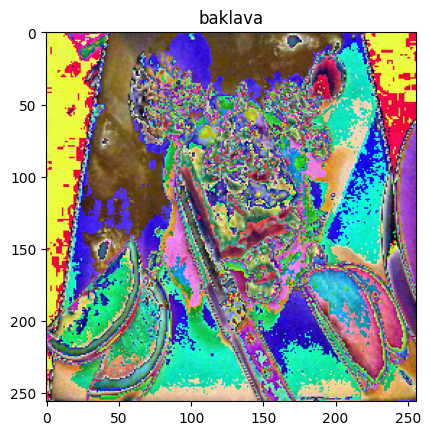

In [20]:
# SHOW AN IMAGE FROM THE SUBSET

def display_image(dataset, index):
    image, label = dataset[index]
    image = to_pil_image(image)
    plt.imshow(image)
    plt.title(train_dataset.classes[label])

display_image(subset_train, 2620)


In [ ]:
# ================ SAMPLE IMAGE FOR ALL CLASSES ================ #
def display_each_class(dataset):
    plt.figure(figsize=(256, 256))  # Adjust the figure size as needed
    for idx in range(0, len(train_dataset.classes)):
        plt.subplot(26, 4, idx+1)
        plt.imshow(dataset[idx * 750][0])  # Indexing starts from 0
        plt.title(dataset.classes[dataset[idx * 750][1]])
        # plt.xticks([])
        # plt.yticks([])

    plt.tight_layout()  # Move this outside the loop
    # plt.show()
    plt.savefig("output.png")

display_each_class(train_dataset)

In [ ]:
# General function to display the histogram of the images
def list_image_paths(root_dir = "data/food-101/images", extensions=['.jpg', '.jpeg', '.png']):
    image_paths = []

    for root, dirs, files in os.walk(root_dir):
        #write in red
        # print('\033[91m' + root)
        for file in files:
            #write in blue
            # print('\033[94m' + file)
    
            if any(file.lower().endswith(ext) for ext in extensions):
                image_paths.append(os.path.join(root, file))
                break
            

    return image_paths

def display_histogram(image_paths):
    # Load images and extract pixel values
    images = [np.array(Image.open(image_path).convert("RGB")) for image_path in image_paths]
    
    # Flatten the 3D array of pixel values into a 1D array
    pixel_values_flat = np.concatenate([image.flatten() for image in images])

    # print('Total number of pixels:', len(pixel_values_flat))

    # Make a histogram for the pixel values
    plt.figure(figsize=(20, 10))
    plt.hist(pixel_values_flat, bins=20, range=(0, 255), color='blue', edgecolor='black')
    plt.title('Distribution of Pixel Intensities in the Dataset')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.show()

test = list_image_paths()
# print(len(test))
# print(test[0:101])
display_histogram(test)

In [9]:
# =======================   CNN MODEL    ======================= #
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Input shape: [batch_size, 3, 256, 256]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Fully connected layer
        self.fc1 = nn.Linear(64 * 64 * 64, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
# =======================   CNN MODEL    ======================= #
class SimpleCNN2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN2, self).__init__()
        # Input shape: [batch_size, 3, 256, 256]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 128 * 128, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 128 * 128)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [11]:
class SimpleCNN3(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.2):
        super(SimpleCNN3, self).__init__()
        # Input shape: [batch_size, 3, 256, 256]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after the first convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after the second convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # BatchNorm after the third convolutional layer
        # Fully connected layer
        self.fc1 = nn.Linear(128 * 128 * 128, 1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)  # BatchNorm after the first fully connected layer
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout before the first fully connected layer
        self.fc2 = nn.Linear(1024, 1024)
        self.bn_fc2 = nn.BatchNorm1d(1024)  # BatchNorm after the second fully connected layer
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout before the second fully connected layer
        self.fc3 = nn.Linear(1024, 1024)
        self.bn_fc3 = nn.BatchNorm1d(1024)  # BatchNorm after the third fully connected layer
        self.dropout3 = nn.Dropout(dropout_prob)  # Dropout before the third fully connected layer
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Apply BatchNorm after the first convolutional layer
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Apply BatchNorm after the second convolutional layer
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Apply BatchNorm after the third convolutional layer
        x = x.view(-1, 128 * 128 * 128)  # Flatten the tensor
        x = F.relu(self.bn_fc1(self.fc1(x)))  # Apply BatchNorm after the first fully connected layer
        x = self.dropout1(x)  # Apply dropout before the first fully connected layer
        x = F.relu(self.bn_fc2(self.fc2(x)))  # Apply BatchNorm after the second fully connected layer
        x = self.dropout2(x)  # Apply dropout before the second fully connected layer
        x = F.relu(self.bn_fc3(self.fc3(x)))  # Apply BatchNorm after the third fully connected layer
        x = self.dropout3(x)  # Apply dropout before the third fully connected layer
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [12]:
class CustomImageClassifier(nn.Module):
   def __init__(self, num_classes):
       super(CustomImageClassifier, self).__init__()
      
       # Load a pre-trained model (e.g., ResNet)
       self.model = models.resnet18(pretrained=True)
      
       # Freeze the parameters of the model
       for param in self.model.parameters():
           param.requires_grad = False


       # Assuming ResNet18 is used, the in_features for the first added linear layer
       in_features = self.model.fc.in_features


       # Replace the fully connected layer
       self.model.fc = nn.Sequential(
           nn.Linear(in_features, 512),
           nn.ReLU(),
           nn.BatchNorm1d(512),
           nn.Dropout(0.5),
           nn.Linear(512, 256),
           nn.ReLU(),
           nn.BatchNorm1d(256),
           nn.Dropout(0.5),
           nn.Linear(256, num_classes)
       )


   def forward(self, x):
       return self.model(x)

In [ ]:
# # Hyperparameters
# num_epochs = 5
# batch_size = 32
# num_classes = 5 # ? temporary 5
# learning_rate = 0.001
# num_folds = 5  # Number of folds for K-fold cross-validation

# # Initialize KFold for cross-validation
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

# best_model = None
# best_val_accuracy = 0.0

# for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
#     print(f"Fold {fold + 1}/{num_folds}")

#     # Initialize model, loss function, and optimizer
#     model = SimpleCNN(num_classes)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     # Split the data into training and validation sets for this fold
#     train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
#     val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
#     val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)

#     for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
#         # Training loop
#         model.train()
#         for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"):
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#         # Validation loop
#         model.eval()
#         total_correct = 0
#         total_samples = 0
#         with torch.no_grad():
#             for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", unit="batch"):
#                 outputs = model(images)
#                 _, predicted = torch.max(outputs, 1)
#                 total_samples += labels.size(0)
#                 total_correct += (predicted == labels).sum().item()

#         val_accuracy = total_correct / total_samples
#         print(f"Epoch [{epoch + 1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.4f}")

#         # Check if this model has the best validation accuracy
#         if val_accuracy > best_val_accuracy:
#             best_val_accuracy = val_accuracy
#             best_model = model.state_dict()

# # After K-fold cross-validation, use the best model for testing
# model.load_state_dict(best_model)
# model.eval()

# # Define the data loader for testing
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Testing loop
# model.eval()
# total_correct = 0
# total_samples = 0
# with torch.no_grad():
#     for images, labels in test_loader:
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)
#         total_samples += labels.size(0)
#         total_correct += (predicted == labels).sum().item()

# test_accuracy = total_correct / total_samples
# print(f"Test Accuracy: {test_accuracy:.4f}")

In [13]:
# ======================= SMALL MODEL TRAINING FOR 5 CLASSES ======================= #
# Hyperparameters
num_epochs = 20
batch_size = 32
num_classes = 5 # ? temporary 5
learning_rate = 0.001
num_folds = 5  # Number of folds for K-fold cross-validation

# Initialize KFold for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

best_model = None
best_val_accuracy = 0.0

for fold, (train_indices, val_indices) in enumerate(kf.split(subset_train)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Initialize model, loss function, and optimizer
    model = CustomImageClassifier(num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Split the data into training and validation sets for this fold
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(subset_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(subset_train, batch_size=batch_size, sampler=val_sampler)

    for epoch in tqdm(range(num_epochs), desc="Training", unit="epoch"):
        # Training loop
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation loop
        model.eval()
        total_correct = 0
        total_samples = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} (Validation)", unit="batch"):
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

        val_accuracy = total_correct / total_samples
        
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Validation Accuracy: {val_accuracy:.4f}")

        # Check if this model has the best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()

# After K-fold cross-validation, use the best model for testing
model.load_state_dict(best_model)
model.eval()

# Save the best model
torch.save(best_model, 'bestmodel.pt')

# Define the data loader for testing
test_loader = torch.utils.data.DataLoader(subset_test, batch_size=batch_size, shuffle=False)

# Testing loop
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

Fold 1/5


/Users/efe/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/efe/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/efe/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 11.1MB/s]
Training:   5%|▌         | 1/20 [02:50<53:53, 170.20s/epoch]

Epoch [1/20] - Validation Accuracy: 0.7707


Training:  10%|█         | 2/20 [05:40<51:03, 170.18s/epoch]

Epoch [2/20] - Validation Accuracy: 0.7760


Training:  15%|█▌        | 3/20 [08:29<48:02, 169.58s/epoch]

Epoch [3/20] - Validation Accuracy: 0.7787


Training:  20%|██        | 4/20 [11:19<45:17, 169.85s/epoch]

Epoch [4/20] - Validation Accuracy: 0.7893


Training:  25%|██▌       | 5/20 [14:09<42:27, 169.84s/epoch]

Epoch [5/20] - Validation Accuracy: 0.7840


Training:  30%|███       | 6/20 [17:01<39:48, 170.61s/epoch]

Epoch [6/20] - Validation Accuracy: 0.7880


Training:  35%|███▌      | 7/20 [19:52<37:01, 170.87s/epoch]

Epoch [7/20] - Validation Accuracy: 0.7853


Training:  40%|████      | 8/20 [22:42<34:06, 170.53s/epoch]

Epoch [8/20] - Validation Accuracy: 0.7867


Training:  45%|████▌     | 9/20 [25:32<31:12, 170.18s/epoch]

Epoch [9/20] - Validation Accuracy: 0.7773


Training:  50%|█████     | 10/20 [28:20<28:15, 169.50s/epoch]

Epoch [10/20] - Validation Accuracy: 0.7880


Training:  55%|█████▌    | 11/20 [31:06<25:16, 168.50s/epoch]

Epoch [11/20] - Validation Accuracy: 0.7907


Training:  60%|██████    | 12/20 [33:53<22:25, 168.14s/epoch]

Epoch [12/20] - Validation Accuracy: 0.7933


Training:  65%|██████▌   | 13/20 [36:38<19:30, 167.22s/epoch]

Epoch [13/20] - Validation Accuracy: 0.7813


Training:  70%|███████   | 14/20 [39:24<16:40, 166.71s/epoch]

Epoch [14/20] - Validation Accuracy: 0.7667


Training:  75%|███████▌  | 15/20 [42:09<13:52, 166.40s/epoch]

Epoch [15/20] - Validation Accuracy: 0.8000


Training:  80%|████████  | 16/20 [44:55<11:04, 166.12s/epoch]

Epoch [16/20] - Validation Accuracy: 0.7947


Training:  85%|████████▌ | 17/20 [47:41<08:17, 165.98s/epoch]

Epoch [17/20] - Validation Accuracy: 0.8093


Training:  90%|█████████ | 18/20 [50:27<05:32, 166.25s/epoch]

Epoch [18/20] - Validation Accuracy: 0.8133


Training:  95%|█████████▌| 19/20 [53:12<02:45, 165.89s/epoch]

Epoch [19/20] - Validation Accuracy: 0.7933


Training: 100%|██████████| 20/20 [55:59<00:00, 167.99s/epoch]


Epoch [20/20] - Validation Accuracy: 0.7907
Fold 2/5


Training:   5%|▌         | 1/20 [02:48<53:17, 168.31s/epoch]

Epoch [1/20] - Validation Accuracy: 0.8000


Training:  10%|█         | 2/20 [05:32<49:45, 165.85s/epoch]

Epoch [2/20] - Validation Accuracy: 0.7987


Training:  15%|█▌        | 3/20 [08:17<46:49, 165.29s/epoch]

Epoch [3/20] - Validation Accuracy: 0.8120


Training:  20%|██        | 4/20 [11:02<44:03, 165.21s/epoch]

Epoch [4/20] - Validation Accuracy: 0.8160


Training:  25%|██▌       | 5/20 [13:47<41:16, 165.11s/epoch]

Epoch [5/20] - Validation Accuracy: 0.8187


Training:  30%|███       | 6/20 [16:32<38:34, 165.35s/epoch]

Epoch [6/20] - Validation Accuracy: 0.8213


Training:  35%|███▌      | 7/20 [19:17<35:46, 165.14s/epoch]

Epoch [7/20] - Validation Accuracy: 0.8320


Training:  40%|████      | 8/20 [22:02<33:00, 165.02s/epoch]

Epoch [8/20] - Validation Accuracy: 0.8200


Training:  45%|████▌     | 9/20 [24:47<30:14, 164.91s/epoch]

Epoch [9/20] - Validation Accuracy: 0.8040


Training:  50%|█████     | 10/20 [27:32<27:30, 165.01s/epoch]

Epoch [10/20] - Validation Accuracy: 0.8187


Training:  55%|█████▌    | 11/20 [30:16<24:42, 164.75s/epoch]

Epoch [11/20] - Validation Accuracy: 0.8320


Training:  60%|██████    | 12/20 [33:01<21:58, 164.86s/epoch]

Epoch [12/20] - Validation Accuracy: 0.8200


Training:  65%|██████▌   | 13/20 [35:45<19:12, 164.69s/epoch]

Epoch [13/20] - Validation Accuracy: 0.8160


Training:  70%|███████   | 14/20 [38:31<16:29, 164.88s/epoch]

Epoch [14/20] - Validation Accuracy: 0.8147


Training:  75%|███████▌  | 15/20 [41:15<13:43, 164.64s/epoch]

Epoch [15/20] - Validation Accuracy: 0.8253


Training:  80%|████████  | 16/20 [43:59<10:58, 164.55s/epoch]

Epoch [16/20] - Validation Accuracy: 0.8213


Training:  85%|████████▌ | 17/20 [46:43<08:13, 164.40s/epoch]

Epoch [17/20] - Validation Accuracy: 0.8160


Training:  90%|█████████ | 18/20 [49:28<05:28, 164.46s/epoch]

Epoch [18/20] - Validation Accuracy: 0.8200


Training:  95%|█████████▌| 19/20 [52:13<02:44, 164.76s/epoch]

Epoch [19/20] - Validation Accuracy: 0.8227


Training: 100%|██████████| 20/20 [54:58<00:00, 164.94s/epoch]


Epoch [20/20] - Validation Accuracy: 0.8240
Fold 3/5


Training:   5%|▌         | 1/20 [02:44<52:07, 164.58s/epoch]

Epoch [1/20] - Validation Accuracy: 0.7720


Training:  10%|█         | 2/20 [05:29<49:30, 165.05s/epoch]

Epoch [2/20] - Validation Accuracy: 0.7893


Training:  15%|█▌        | 3/20 [08:15<46:46, 165.07s/epoch]

Epoch [3/20] - Validation Accuracy: 0.7827


Training:  20%|██        | 4/20 [10:59<43:59, 164.98s/epoch]

Epoch [4/20] - Validation Accuracy: 0.7853


Training:  25%|██▌       | 5/20 [13:44<41:13, 164.93s/epoch]

Epoch [5/20] - Validation Accuracy: 0.7813


Training:  30%|███       | 6/20 [16:30<38:30, 165.06s/epoch]

Epoch [6/20] - Validation Accuracy: 0.7720


Training:  35%|███▌      | 7/20 [19:15<35:46, 165.14s/epoch]

Epoch [7/20] - Validation Accuracy: 0.8027


Training:  40%|████      | 8/20 [22:00<33:01, 165.12s/epoch]

Epoch [8/20] - Validation Accuracy: 0.7560


Training:  45%|████▌     | 9/20 [24:45<30:15, 165.09s/epoch]

Epoch [9/20] - Validation Accuracy: 0.8067


Training:  50%|█████     | 10/20 [27:30<27:29, 164.94s/epoch]

Epoch [10/20] - Validation Accuracy: 0.8133


Training:  55%|█████▌    | 11/20 [30:15<24:45, 165.09s/epoch]

Epoch [11/20] - Validation Accuracy: 0.8160


Training:  60%|██████    | 12/20 [33:01<22:02, 165.28s/epoch]

Epoch [12/20] - Validation Accuracy: 0.8000


Training:  65%|██████▌   | 13/20 [35:46<19:16, 165.17s/epoch]

Epoch [13/20] - Validation Accuracy: 0.8027


Training:  70%|███████   | 14/20 [38:30<16:30, 165.04s/epoch]

Epoch [14/20] - Validation Accuracy: 0.8080


Training:  75%|███████▌  | 15/20 [41:15<13:44, 164.88s/epoch]

Epoch [15/20] - Validation Accuracy: 0.8053


Training:  80%|████████  | 16/20 [44:02<11:02, 165.62s/epoch]

Epoch [16/20] - Validation Accuracy: 0.8187


Training:  85%|████████▌ | 17/20 [46:53<08:21, 167.03s/epoch]

Epoch [17/20] - Validation Accuracy: 0.8067


Training:  90%|█████████ | 18/20 [49:42<05:35, 167.91s/epoch]

Epoch [18/20] - Validation Accuracy: 0.7907


Training:  95%|█████████▌| 19/20 [52:32<02:48, 168.46s/epoch]

Epoch [19/20] - Validation Accuracy: 0.8000


Training: 100%|██████████| 20/20 [55:21<00:00, 166.09s/epoch]


Epoch [20/20] - Validation Accuracy: 0.7907
Fold 4/5


Training:   5%|▌         | 1/20 [02:49<53:40, 169.52s/epoch]

Epoch [1/20] - Validation Accuracy: 0.7600


Training:  10%|█         | 2/20 [05:39<50:59, 169.98s/epoch]

Epoch [2/20] - Validation Accuracy: 0.7827


Training:  15%|█▌        | 3/20 [08:31<48:21, 170.70s/epoch]

Epoch [3/20] - Validation Accuracy: 0.7973


Training:  20%|██        | 4/20 [11:23<45:37, 171.12s/epoch]

Epoch [4/20] - Validation Accuracy: 0.7533


Training:  25%|██▌       | 5/20 [14:13<42:44, 170.96s/epoch]

Epoch [5/20] - Validation Accuracy: 0.7813


Training:  30%|███       | 6/20 [17:03<39:48, 170.58s/epoch]

Epoch [6/20] - Validation Accuracy: 0.7867


Training:  35%|███▌      | 7/20 [19:52<36:51, 170.10s/epoch]

Epoch [7/20] - Validation Accuracy: 0.7893


Training:  40%|████      | 8/20 [22:45<34:10, 170.91s/epoch]

Epoch [8/20] - Validation Accuracy: 0.7867


Training:  45%|████▌     | 9/20 [25:36<31:19, 170.87s/epoch]

Epoch [9/20] - Validation Accuracy: 0.7840


Training:  50%|█████     | 10/20 [28:27<28:28, 170.89s/epoch]

Epoch [10/20] - Validation Accuracy: 0.7827


Training:  55%|█████▌    | 11/20 [31:17<25:36, 170.76s/epoch]

Epoch [11/20] - Validation Accuracy: 0.8013


Training:  60%|██████    | 12/20 [34:08<22:46, 170.87s/epoch]

Epoch [12/20] - Validation Accuracy: 0.7853


Training:  65%|██████▌   | 13/20 [36:59<19:56, 170.92s/epoch]

Epoch [13/20] - Validation Accuracy: 0.7933


Training:  70%|███████   | 14/20 [39:49<17:03, 170.63s/epoch]

Epoch [14/20] - Validation Accuracy: 0.7773


Training:  75%|███████▌  | 15/20 [42:39<14:11, 170.33s/epoch]

Epoch [15/20] - Validation Accuracy: 0.7947


Training:  80%|████████  | 16/20 [45:31<11:23, 170.85s/epoch]

Epoch [16/20] - Validation Accuracy: 0.7747


Training:  85%|████████▌ | 17/20 [48:24<08:34, 171.49s/epoch]

Epoch [17/20] - Validation Accuracy: 0.7920


Training:  90%|█████████ | 18/20 [51:17<05:43, 171.91s/epoch]

Epoch [18/20] - Validation Accuracy: 0.7800


Training:  95%|█████████▌| 19/20 [54:08<02:51, 171.83s/epoch]

Epoch [19/20] - Validation Accuracy: 0.7907


Training: 100%|██████████| 20/20 [57:00<00:00, 171.02s/epoch]


Epoch [20/20] - Validation Accuracy: 0.7947
Fold 5/5


Training:   5%|▌         | 1/20 [02:50<54:06, 170.85s/epoch]

Epoch [1/20] - Validation Accuracy: 0.7840


Training:  10%|█         | 2/20 [05:44<51:39, 172.21s/epoch]

Epoch [2/20] - Validation Accuracy: 0.7827


Training:  15%|█▌        | 3/20 [08:36<48:48, 172.26s/epoch]

Epoch [3/20] - Validation Accuracy: 0.7867


Training:  20%|██        | 4/20 [11:27<45:47, 171.69s/epoch]

Epoch [4/20] - Validation Accuracy: 0.7987


Training:  25%|██▌       | 5/20 [14:19<42:58, 171.93s/epoch]

Epoch [5/20] - Validation Accuracy: 0.7920


Training:  30%|███       | 6/20 [17:10<40:03, 171.65s/epoch]

Epoch [6/20] - Validation Accuracy: 0.7893


Training:  35%|███▌      | 7/20 [20:02<37:10, 171.56s/epoch]

Epoch [7/20] - Validation Accuracy: 0.8000


Training:  40%|████      | 8/20 [22:52<34:16, 171.38s/epoch]

Epoch [8/20] - Validation Accuracy: 0.7853


Training:  45%|████▌     | 9/20 [25:44<31:24, 171.30s/epoch]

Epoch [9/20] - Validation Accuracy: 0.7893


Training:  50%|█████     | 10/20 [28:34<28:31, 171.11s/epoch]

Epoch [10/20] - Validation Accuracy: 0.7973


Training:  55%|█████▌    | 11/20 [31:26<25:41, 171.23s/epoch]

Epoch [11/20] - Validation Accuracy: 0.7947


Training:  60%|██████    | 12/20 [34:17<22:49, 171.15s/epoch]

Epoch [12/20] - Validation Accuracy: 0.7813


Training:  65%|██████▌   | 13/20 [37:08<19:57, 171.07s/epoch]

Epoch [13/20] - Validation Accuracy: 0.7907


Training:  70%|███████   | 14/20 [39:59<17:06, 171.05s/epoch]

Epoch [14/20] - Validation Accuracy: 0.8027


Training:  75%|███████▌  | 15/20 [42:50<14:15, 171.03s/epoch]

Epoch [15/20] - Validation Accuracy: 0.7933


Training:  80%|████████  | 16/20 [45:41<11:24, 171.02s/epoch]

Epoch [16/20] - Validation Accuracy: 0.7693


Training:  85%|████████▌ | 17/20 [48:32<08:33, 171.17s/epoch]

Epoch [17/20] - Validation Accuracy: 0.7867


Training:  90%|█████████ | 18/20 [51:24<05:42, 171.31s/epoch]

Epoch [18/20] - Validation Accuracy: 0.7773


Training:  95%|█████████▌| 19/20 [54:14<02:51, 171.01s/epoch]

Epoch [19/20] - Validation Accuracy: 0.7680


Training: 100%|██████████| 20/20 [57:05<00:00, 171.30s/epoch]


Epoch [20/20] - Validation Accuracy: 0.7880
Test Accuracy: 0.9280
